# NYC Property Appraisal - Regression Model

## 1. Data Analysis & Cleaning

In [2]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns=30

In [3]:
data = pd.read_csv('real_estate_data.csv')

It is obvious that *'tx_price'* is the y_label we want to predict.

In [20]:
data.head() # There are three categorical columns

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


In [4]:
data.shape

(1883, 26)

In [5]:
data.isna().sum()

tx_price                0
beds                    0
baths                   0
sqft                    0
year_built              0
lot_size                0
property_type           0
exterior_walls        223
roof                  354
basement              226
restaurants             0
groceries               0
nightlife               0
cafes                   0
shopping                0
arts_entertainment      0
beauty_spas             0
active_life             0
median_age              0
married                 0
college_grad            0
property_tax            0
insurance               0
median_school           0
num_schools             0
tx_year                 0
dtype: int64

The roof and exterior_walls are full of null values and are difficult to estimate effective proxies. So they are dropped. 

In [4]:
data = data.drop(columns=['roof', 'exterior_walls'])

In [5]:
data.basement.unique()

array([nan,  1.])

In [6]:
data.basement = data.basement.fillna(0)

In [7]:
data.basement.unique() # No more NaN values!

array([0., 1.])

### Visualise distribution & check if any outliers or erroneous values 

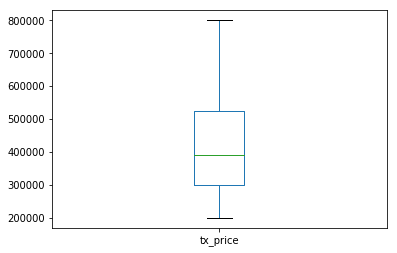

In [10]:
data.tx_price.plot.box() # transaction price between $200K to $800K (USD)

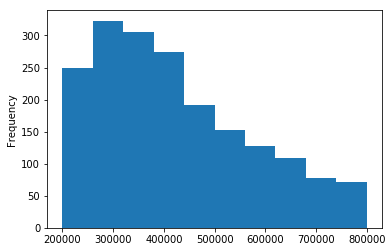

In [11]:
data.tx_price.plot.hist() 

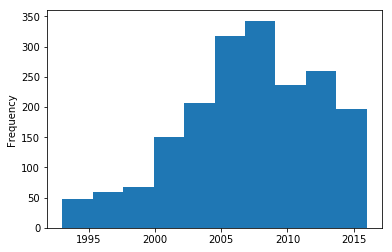

In [12]:
data.tx_year.plot.hist() # most transactions after 2000s

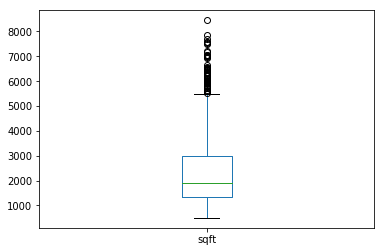

In [13]:
data.sqft.plot.box() 

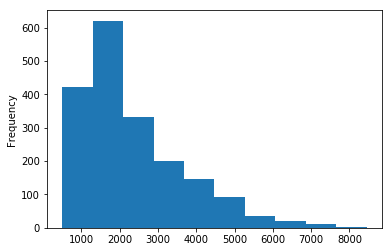

In [14]:
data.sqft.plot.hist() 

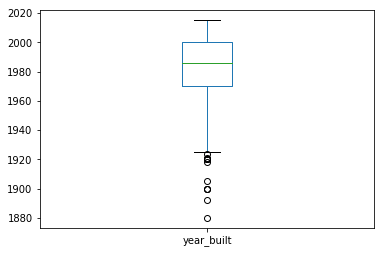

In [15]:
data.year_built.plot.box()

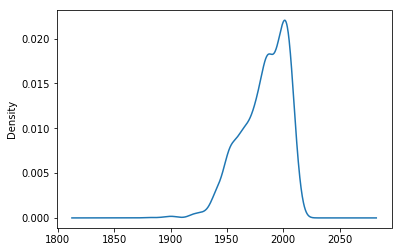

In [16]:
data.year_built.plot.kde() # the construction years are centered around 1970 to 2010

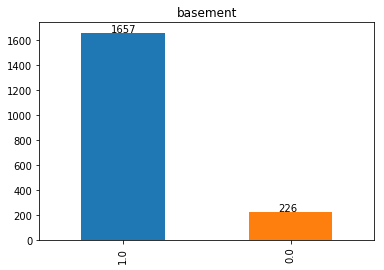

In [17]:
ax = data.basement.value_counts().plot.bar(title='basement') # most are with basement
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + 0.175, p.get_height() * 1.005))

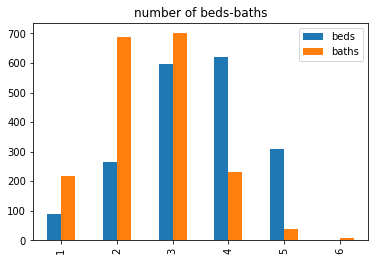

In [18]:
data[['beds','baths']].apply(pd.value_counts).plot.bar(title='number of beds-baths')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + 0.175, p.get_height() * 1.005))

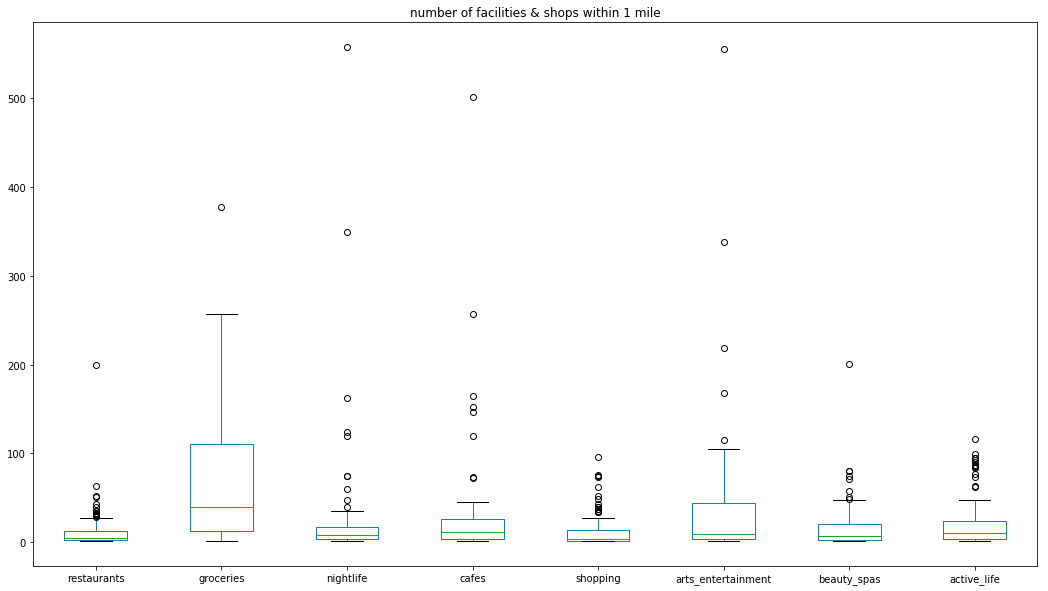

In [19]:
ax = data[['restaurants', 'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment', 'beauty_spas', 'active_life']].\
    apply((pd.value_counts)).plot.box(figsize=(18,10), title='number of facilities & shops within 1 mile')
    # number of facilities within 1 mile

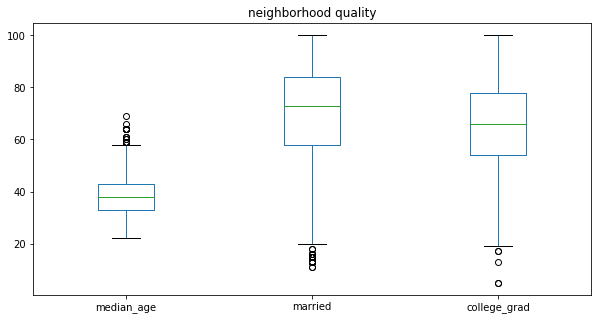

In [20]:
data[['median_age', 'married', 'college_grad']].plot.box(figsize=(10,5), title='neighborhood quality') # neighborhood quality

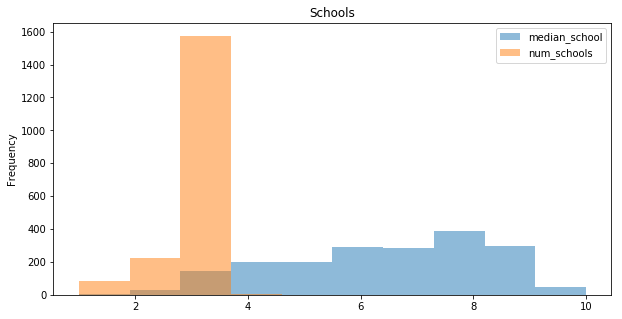

In [21]:
data[['median_school', 'num_schools']].plot.hist(figsize=(10,5), alpha=0.5, title='Schools')

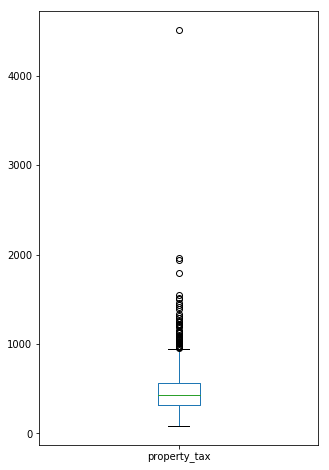

In [22]:
data.property_tax.plot.box(figsize=(5,8))

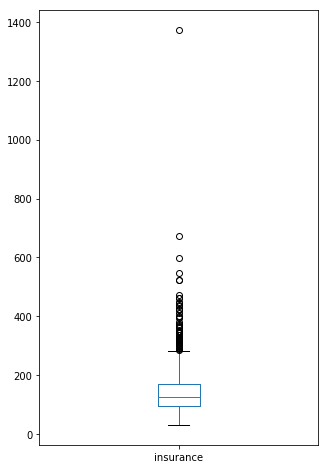

In [23]:
data.insurance.plot.box(figsize=(5,8))

## 2.Feature Engineering

* One important missing feature is the age of the property!
* Which is simply: *tx_year - year_built*

In [24]:
data.year_built.sort_values().unique()

array([1880, 1892, 1900, 1905, 1918, 1920, 1921, 1924, 1925, 1927, 1929,
       1930, 1932, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015])

In [25]:
data['age'] = data.apply(lambda x: x['tx_year'] - x['year_built'], axis=1 )

In [26]:
data.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,age
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,0
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,41
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,49
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,5
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,10


In [27]:
data.age.sort_values().unique()

array([ -8,  -7,  -4,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  77,  78,  79,  80,  82,  85,  86,  89,  90,  94,
       101, 103, 104, 110, 113, 114])

In [28]:
data.iloc[:,4::19].sort_values(by='year_built', ascending=False)[:10]

,year_built,tx_year
1540,2015,2014
1864,2015,2013
1828,2015,2007
1840,2014,2014
1207,2014,2014
1769,2014,2014
0,2013,2013
1818,2013,2013
111,2013,2013
1809,2013,2012


Some properties are sold before it finished construction.

That is why we have negative *age* values.

In [29]:
data.drop('property_type', 1, inplace=True)

In [30]:
data.to_csv('data_cooked.csv', index=False) # Now, output to cleaned & engineered table for use

## 3.Modelling

In [47]:
df = pd.read_csv('data_cooked.csv')

In [32]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,age
0,295850,1,1,584,2013,0,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,0
1,216500,1,1,612,1965,0,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,41
2,279900,1,1,615,1963,0,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,49
3,379900,1,1,618,2000,33541,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,5
4,340000,1,1,634,1992,0,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,10


### 3.1Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [61]:
train_X, test_X, train_y, test_y = train_test_split(df.drop('tx_price',1), df.tx_price, random_state=99,
                                                   test_size=0.3, )

In [62]:
print('train_X.shape:', train_X.shape,
     '\ntrain_y.shape:', train_y.shape,
     '\ntest_X.shape:', test_X.shape,
     '\ntest_y.shape:', test_y.shape)

train_X.shape: (1318, 23) 
train_y.shape: (1318,) 
test_X.shape: (565, 23) 
test_y.shape: (565,)


In [63]:
rrr = RandomForestRegressor(n_estimators=100)
rrr = rrr.fit(train_X, train_y)

In [64]:
yhat_rrr = rrr.predict(test_X)
mean_absolute_error(test_y, yhat_rrr)

45746.99316814159

Tuning number of estimators via gridsearch:

In [65]:
def get_mae_rf(num_est, predictors_train, predictors_val, targ_train, targ_val):

    # fitting model with input max_leaf_nodes
    model = RandomForestRegressor(n_estimators=num_est, random_state=0)

    # fitting the model with training dataset
    model.fit(predictors_train, targ_train)

    # making prediction with the test dataset
    preds_val = model.predict(predictors_val)

    # calculate and return the MAE
    mae = mean_absolute_error(targ_val, preds_val)
    return(mae)

In [66]:
import time
start = time.clock()

plot_mae = []
estimator = range(2,100)

for num_est in range(2,100):
    my_mae = get_mae_rf(num_est,train_X,test_X,train_y,test_y)
    print("num_est : %d \t\t Mean Absolute Error:  %d" %(num_est,my_mae))
    plot_mae.append(my_mae)

print (time.clock() - start)

C:\install\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


num_est : 2 		 Mean Absolute Error:  58775
num_est : 3 		 Mean Absolute Error:  54786
num_est : 4 		 Mean Absolute Error:  51000
num_est : 5 		 Mean Absolute Error:  49162
num_est : 6 		 Mean Absolute Error:  47648
num_est : 7 		 Mean Absolute Error:  47152
num_est : 8 		 Mean Absolute Error:  47404
num_est : 9 		 Mean Absolute Error:  47464
num_est : 10 		 Mean Absolute Error:  47479
num_est : 11 		 Mean Absolute Error:  47503
num_est : 12 		 Mean Absolute Error:  47329
num_est : 13 		 Mean Absolute Error:  47571
num_est : 14 		 Mean Absolute Error:  47755
num_est : 15 		 Mean Absolute Error:  47719
num_est : 16 		 Mean Absolute Error:  47538
num_est : 17 		 Mean Absolute Error:  47702
num_est : 18 		 Mean Absolute Error:  47351
num_est : 19 		 Mean Absolute Error:  47075
num_est : 20 		 Mean Absolute Error:  47104
num_est : 21 		 Mean Absolute Error:  47142
num_est : 22 		 Mean Absolute Error:  46920
num_est : 23 		 Mean Absolute Error:  46916
num_est : 24 		 Mean Absolute Error:  46

C:\install\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [40]:
import time
start = time.clock()

plot_mae = []
estimator = range(2,100)

for num_est in range(340,350):
    my_mae = get_mae_rf(num_est,train_X,test_X,train_y,test_y)
    print("num_est : %d \t\t Mean Absolute Error:  %d" %(num_est,my_mae))
    plot_mae.append(my_mae)

print (time.clock() - start)

num_est : 340 		 Mean Absolute Error:  45897
num_est : 341 		 Mean Absolute Error:  45891
num_est : 342 		 Mean Absolute Error:  45873
num_est : 343 		 Mean Absolute Error:  45870
num_est : 344 		 Mean Absolute Error:  45868
num_est : 345 		 Mean Absolute Error:  45865
num_est : 346 		 Mean Absolute Error:  45866
num_est : 347 		 Mean Absolute Error:  45868
num_est : 348 		 Mean Absolute Error:  45884
num_est : 349 		 Mean Absolute Error:  45877
31.643173999999995


Even if we are increasing the number of estimators, it seems that it is not getting any better then the first trial.

At aounrd 350 round, it starts to get better results.

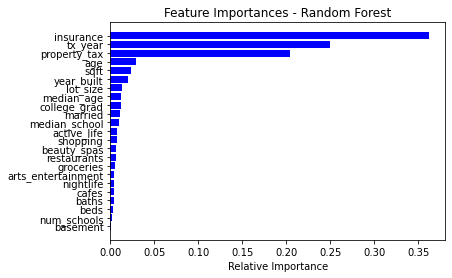

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
features = train_X.columns
importances = rrr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances - Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### 3.2XGBoost

In [42]:
from xgboost import XGBRegressor

In [43]:
xgbr = XGBRegressor()

In [44]:
xgbr.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
xgbr.feature_importances_

array([ 0.03768116,  0.00724638,  0.12028985,  0.06086956,  0.03043478,
        0.00289855,  0.01449275,  0.01594203,  0.0057971 ,  0.01884058,
        0.01304348,  0.01594203,  0.01304348,  0.01594203,  0.01304348,
        0.02173913,  0.03188406,  0.0768116 ,  0.17536232,  0.0173913 ,
        0.        ,  0.2173913 ,  0.07391305], dtype=float32)

In [46]:
train_X.columns

Index(['beds', 'baths', 'sqft', 'year_built', 'lot_size', 'basement',
       'restaurants', 'groceries', 'nightlife', 'cafes', 'shopping',
       'arts_entertainment', 'beauty_spas', 'active_life', 'median_age',
       'married', 'college_grad', 'property_tax', 'insurance', 'median_school',
       'num_schools', 'tx_year', 'age'],
      dtype='object')

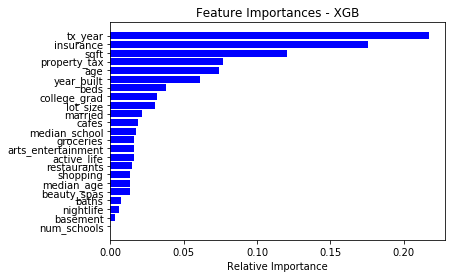

In [47]:
for y,x in sorted(zip(xgbr.feature_importances_, train_X.columns), reverse=False):
    #print (x,y)
    plt.barh(x,y, color='b')
    plt.title('Feature Importances - XGB')
    plt.xlabel('Relative Importance')

In [48]:
yhat_xgb = xgbr.predict(test_X)
mean_absolute_error(test_y, yhat_xgb)

45025.599529867257

### 3.3LightGBM

In [49]:
import lightgbm as lgb

In [50]:
#lgr = lgb.LGBMRegressor(num_leaves=10, n_estimators=150, learning_rate=0.3, max_depth=3, min_child_samples=1)
lgr = lgb.LGBMRegressor()

In [51]:
lgr.fit(train_X, train_y, eval_set=(test_X, test_y))

[1]	valid_0's l2: 2.41605e+10
[2]	valid_0's l2: 2.41369e+10
[3]	valid_0's l2: 2.41134e+10
[4]	valid_0's l2: 2.40895e+10
[5]	valid_0's l2: 2.4066e+10
[6]	valid_0's l2: 2.40422e+10
[7]	valid_0's l2: 2.40184e+10
[8]	valid_0's l2: 2.3995e+10
[9]	valid_0's l2: 2.39712e+10
[10]	valid_0's l2: 2.39475e+10
[11]	valid_0's l2: 2.39238e+10
[12]	valid_0's l2: 2.39004e+10
[13]	valid_0's l2: 2.38767e+10
[14]	valid_0's l2: 2.38531e+10
[15]	valid_0's l2: 2.38298e+10
[16]	valid_0's l2: 2.38062e+10
[17]	valid_0's l2: 2.37826e+10
[18]	valid_0's l2: 2.37593e+10
[19]	valid_0's l2: 2.37358e+10
[20]	valid_0's l2: 2.37123e+10
[21]	valid_0's l2: 2.36891e+10
[22]	valid_0's l2: 2.36656e+10
[23]	valid_0's l2: 2.36421e+10
[24]	valid_0's l2: 2.36187e+10
[25]	valid_0's l2: 2.3595e+10
[26]	valid_0's l2: 2.35714e+10
[27]	valid_0's l2: 2.35483e+10
[28]	valid_0's l2: 2.35247e+10
[29]	valid_0's l2: 2.35016e+10
[30]	valid_0's l2: 2.34781e+10
[31]	valid_0's l2: 2.34551e+10
[32]	valid_0's l2: 2.34316e+10
[33]	valid_0's l2: 2

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [52]:
yhat_lgr = lgr.predict(test_X)
mean_absolute_error(test_y, yhat_lgr)

121103.29577598203

Hmm the mae is bit too high, let's do some manual tuning.

In [53]:
lgr = lgb.LGBMRegressor(n_estimators=10000)
lgr.fit(train_X, train_y, eval_set=(test_X, test_y), verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [54]:
yhat_lgr = lgr.predict(test_X)
mean_absolute_error(test_y, yhat_lgr)

48051.45830198504

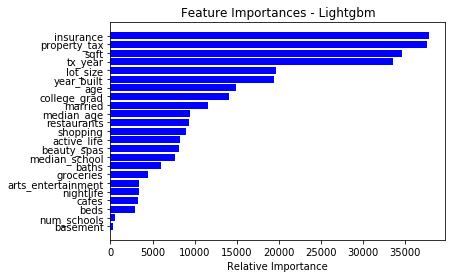

In [55]:
for y,x in sorted(zip(lgr.feature_importances_, train_X.columns), reverse=False):
    #print (x,y)
    plt.barh(x,y, color='b')
    plt.title('Feature Importances - Lightgbm')
    plt.xlabel('Relative Importance')

### 3.3CatBoost

In [56]:
from catboost import CatBoostRegressor

In [57]:
catr = CatBoostRegressor()

In [58]:
catr.fit(train_X, train_y, eval_set=(test_X, test_y))

0:	learn: 437495.0549052	test: 437723.3685829	best: 437723.3685829 (0)	total: 63.2ms	remaining: 1m 3s
1:	learn: 425992.6066846	test: 426501.5594061	best: 426501.5594061 (1)	total: 68.7ms	remaining: 34.3s
2:	learn: 414378.3162013	test: 415015.2880961	best: 415015.2880961 (2)	total: 73.1ms	remaining: 24.3s
3:	learn: 403370.6254951	test: 404239.3898016	best: 404239.3898016 (3)	total: 76.6ms	remaining: 19.1s
4:	learn: 392870.0151548	test: 393944.8265820	best: 393944.8265820 (4)	total: 79.9ms	remaining: 15.9s
5:	learn: 382755.2764853	test: 384110.6477866	best: 384110.6477866 (5)	total: 83.1ms	remaining: 13.8s
6:	learn: 372777.3817192	test: 374242.8287849	best: 374242.8287849 (6)	total: 87ms	remaining: 12.3s
7:	learn: 363170.1680121	test: 364913.2769081	best: 364913.2769081 (7)	total: 90.6ms	remaining: 11.2s
8:	learn: 353497.1600502	test: 355466.7124258	best: 355466.7124258 (8)	total: 93.8ms	remaining: 10.3s
9:	learn: 344367.3405380	test: 346493.2402822	best: 346493.2402822 (9)	total: 97ms	r

In [59]:
yhat_catr = catr.predict(test_X)

In [60]:
mean_absolute_error(test_y, yhat_catr)

43525.695649187161

Hola! Catboost's default setting is already giving the lowest MAE amongst other models!

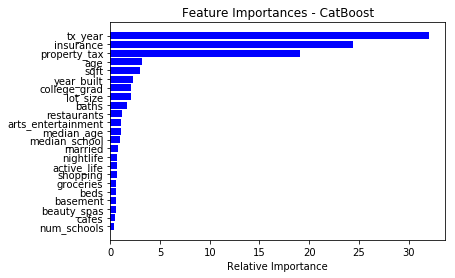

In [61]:
for y,x in sorted(zip(catr.feature_importances_, train_X.columns), reverse=False):
    #print (x,y)
    plt.barh(x,y, color='b')
    plt.title('Feature Importances - CatBoost')
    plt.xlabel('Relative Importance')

## 4.Results

#### 4 different tree-based model are tested with MAE:
* Random Forest (default): 46052
* Xgboost (default): 45025
* Lightgbm (tuned): 48051
* Catboost (default): 43525

As such, this is significantly better then the $70,000 MAE by industrial appraisers! *(Are property appraisers going to be replaced by machine learning!?)*

Next Step: Tuning parameters of each model.

For project background and documentation, please refer to README file.

## 5.Decision Tree

In [96]:
y=df['tx_price']

In [97]:
y

0       295850
1       216500
2       279900
3       379900
4       340000
         ...  
1878    385000
1879    690000
1880    600000
1881    759900
1882    735000
Name: tx_price, Length: 1883, dtype: int64

In [79]:
df.columns

Index(['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size',
       'basement', 'restaurants', 'groceries', 'nightlife', 'cafes',
       'shopping', 'arts_entertainment', 'beauty_spas', 'active_life',
       'median_age', 'married', 'college_grad', 'property_tax', 'insurance',
       'median_school', 'num_schools', 'tx_year', 'age'],
      dtype='object')

In [89]:
predictors=['tx_year','insurance','property_tax','age','sqft']

In [90]:
X=df[predictors]

In [91]:
X.head()

,tx_year,insurance,property_tax,age,sqft
0,2013,81.0,234.0,0,584
1,2006,51.0,169.0,41,612
2,2012,74.0,216.0,49,615
3,2005,92.0,265.0,5,618
4,2002,30.0,88.0,10,634


In [92]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [93]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

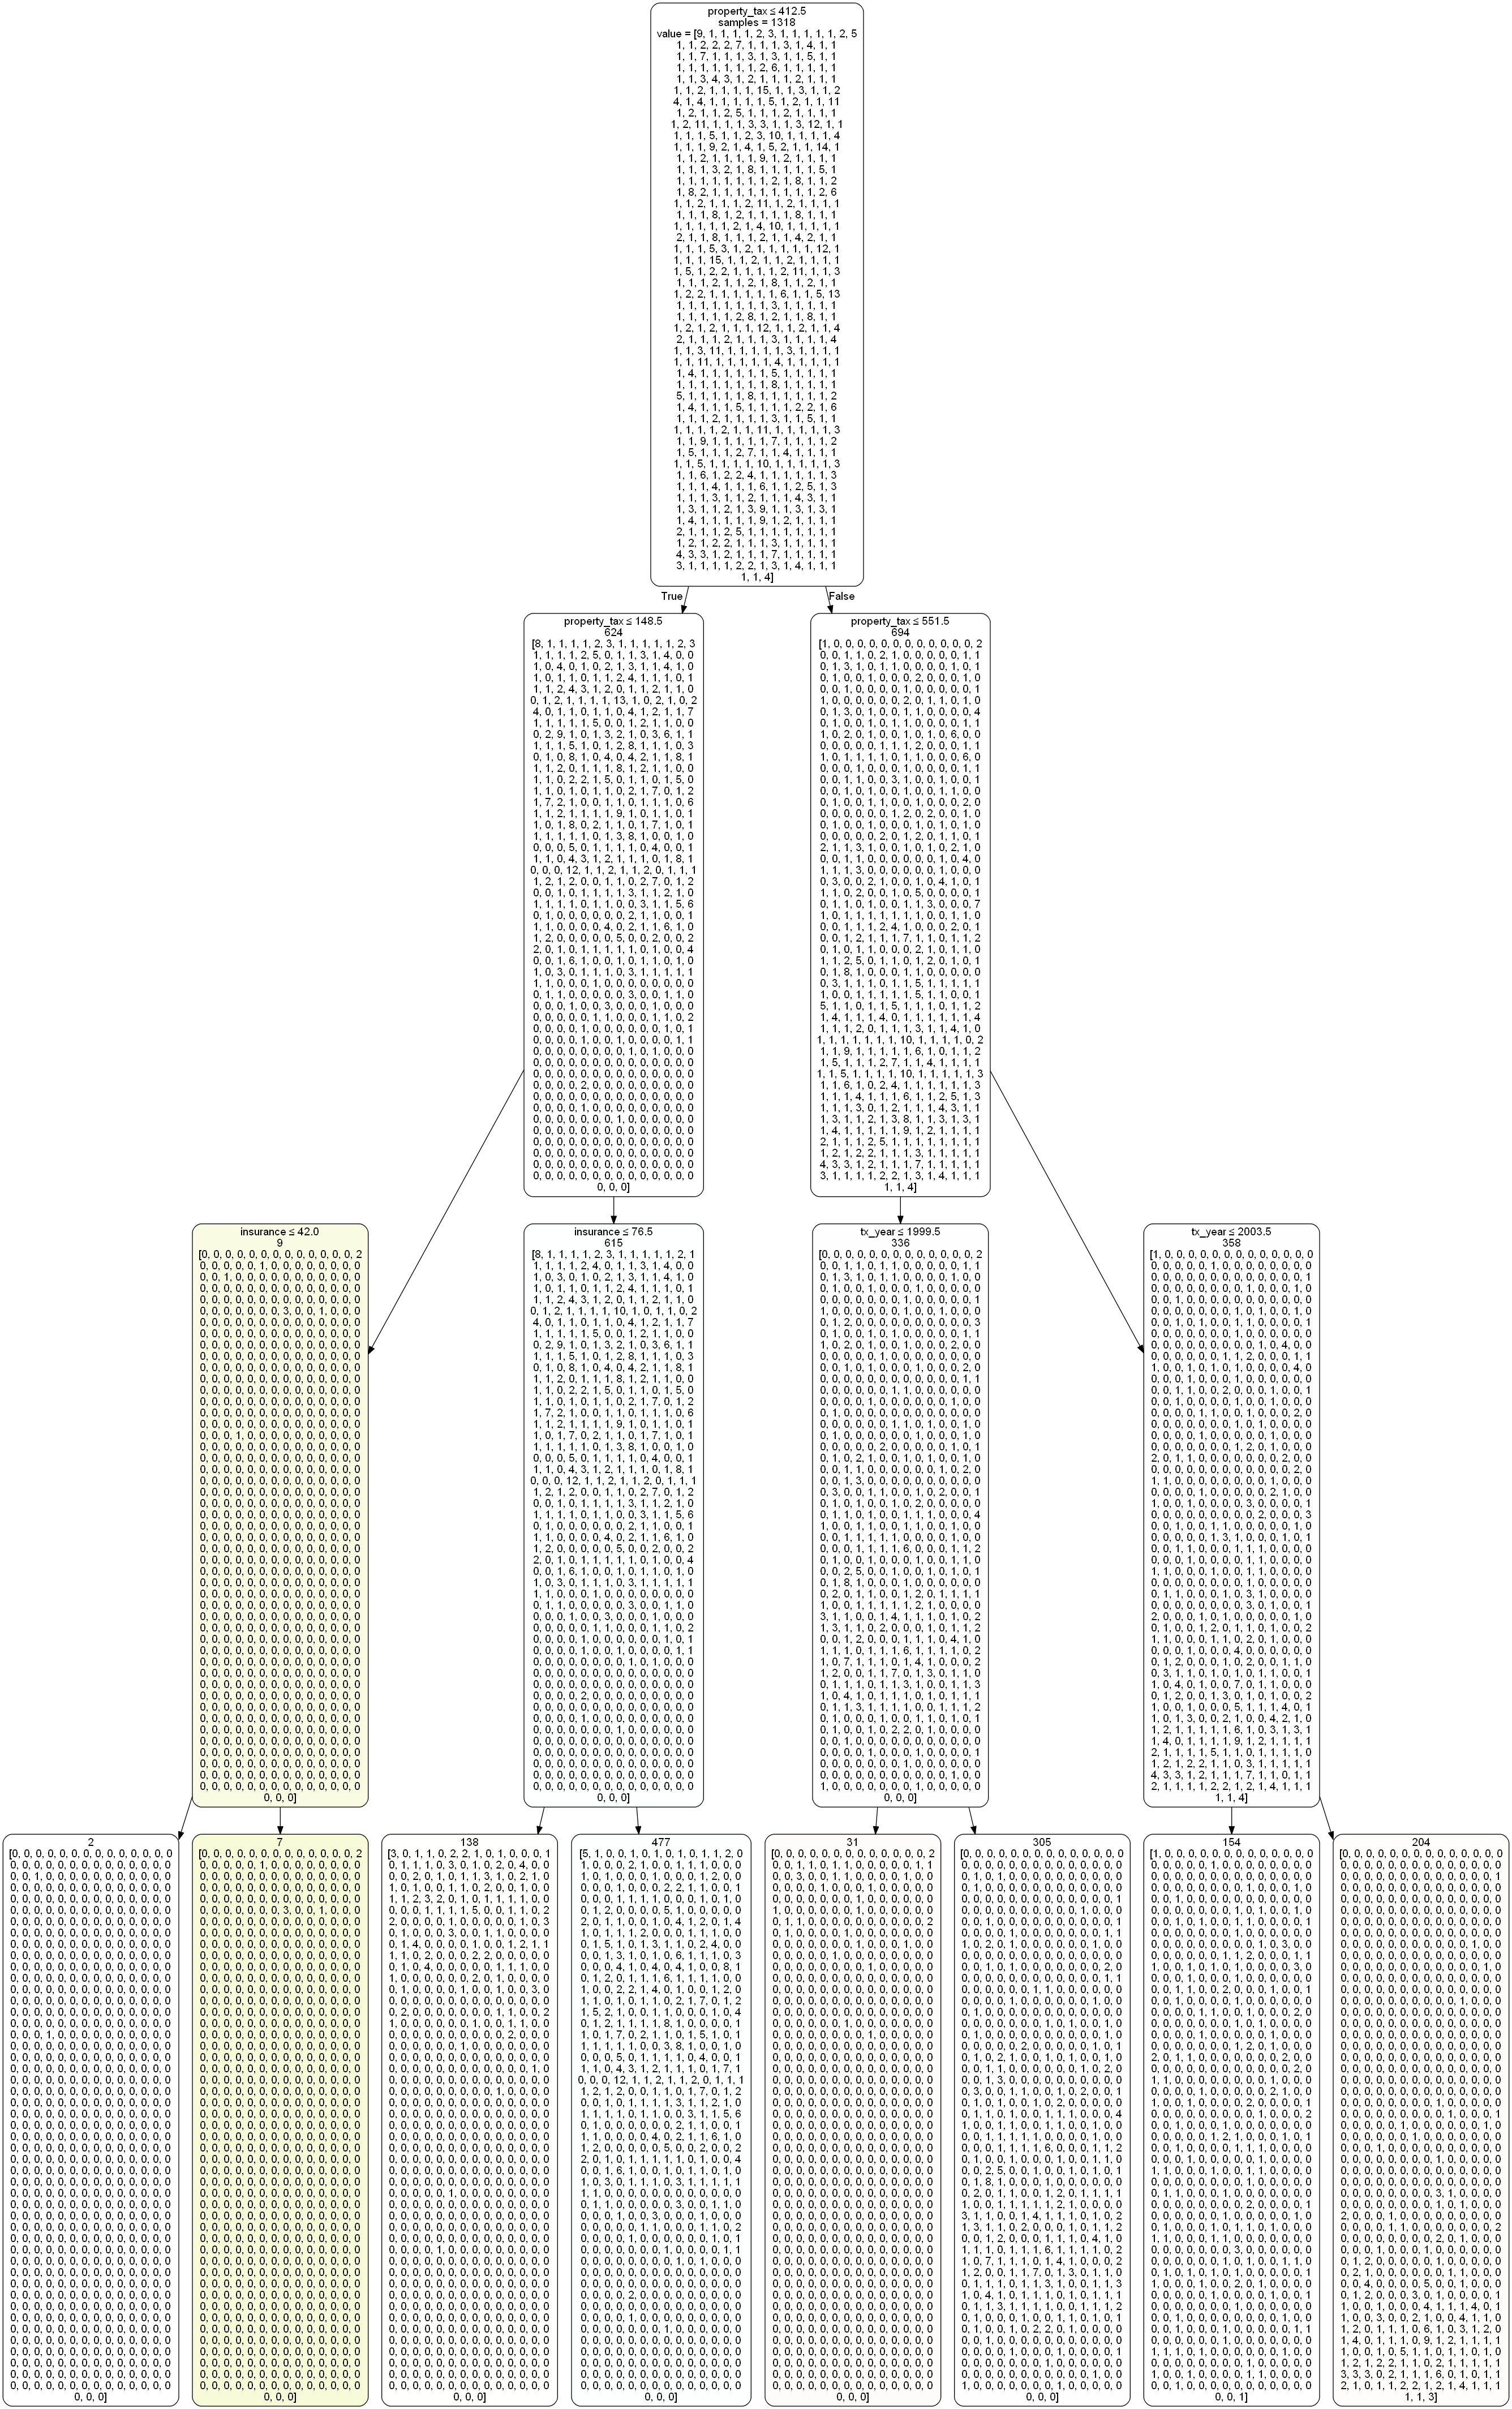

In [95]:
DecisionTree = DecisionTreeClassifier(max_depth =3)
DecisionTree.fit(train_X, train_y)

plotDecisionTree(DecisionTree, feature_names=train_X.columns)

In [98]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score

In [99]:
classificationSummary(train_y, DecisionTree.predict(train_X))
classificationSummary(valid_y, DecisionTree.predict(valid_X))

Confusion Matrix (Accuracy 0.0334)

       Prediction
Actual   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234

   623   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

       Prediction
Actual   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243

In [100]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

In [101]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

In [102]:
y_pred, y_pred_prob = get_predictions(DecisionTree, train_X, train_y, valid_X)
print_scores(valid_y,y_pred,y_pred_prob)

train-set confusion matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
test-set confusion matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## 6.Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 1, solver = 'liblinear')
lr.fit(train_X, train_y)

print('intercept ', lr.intercept_[0])
print(pd.DataFrame({'coeff': lr.coef_[0]}, index=train_X.columns))
print()

C:\install\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


intercept  9.319589427720196e-06
                 coeff
tx_year      -0.001768
insurance    -0.018695
property_tax  0.004587
age           0.032714
sqft         -0.001308



In [105]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
print("precision score: ", precision_score(valid_y,lr.predict(valid_X)))
print("recall score: ", recall_score(valid_y,lr.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,lr.predict(valid_X)))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].